In [ ]:
# -*- coding: utf-8 -*-
"""Data Preprocessing.
===================================================
Version | Last Modified |  Author       | Commment
---------------------------------------------------
0.0   | 10 Sep 21       | J. Charlier   | initial version
0.1   | 15 Oct 21       | J. Charlier   | updated version
0.2   | 16 Oct 21       | J. Charlier   | updated version
0.3   | 17 Oct 21       | J. Charlier   | updated version
0.4   | 20 Oct 21       | J. Charlier   | updated version
0.5   | 21 Oct 21       | J. Charlier   | updated version with pkl file
0.6   | 01 Mar 22       | J. Charlier   | updated version for guideseq encoding
===================================================
comments:
>> the encoder class is inherited from
  [1] "CRISPR-Net: A Recurrent Convolutional Network Quantiﬁes
  CRISPR Off-Target Activities with Mismatches and Indels", J. Lin et al
  https://onlinelibrary.wiley.com/doi/epdf/10.1002/advs.201903562
"""

In [ ]:
__date__='20211122'
__revised__='20220301'
__author__='Jeremy Charlier'
# append drive directory to python sys path
import sys
path_to_module = 'MODULE_PATH'
sys.path.append(path_to_module)
sys.path.append(path_to_module+'/code/')
sys.path.append(path_to_module)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
fpath = 'guideseq.csv'
dfGuideSeq = pd.read_csv(path_to_module+fpath, sep=',')
dfGuideSeq = dfGuideSeq.drop(columns='nameLong')
dfGuideSeq = dfGuideSeq.drop_duplicates(
  subset=['otSeq'], keep=False, ignore_index=True)

In [ ]:
dfGuideSeq.head()

,name,guideSeq,otSeq,label
0,VEGFA_site1,GGGTGGGGGGAGTTTGCTCCTGG,TAGTGGAGGGAGCTTGCTCCTGG,0
1,VEGFA_site1,GGGTGGGGGGAGTTTGCTCCTGG,GGGGAGGGGAAGTTTGCTCCTGG,0
2,VEGFA_site1,GGGTGGGGGGAGTTTGCTCCTGG,GGGAGGGTGGAGTTTGCTCCTGG,0
3,VEGFA_site1,GGGTGGGGGGAGTTTGCTCCTGG,CGGGGGAGGGAGTTTGCTCCTGG,0
4,VEGFA_site1,GGGTGGGGGGAGTTTGCTCCAGG,CTGGTGGGGGAGCTTGCTCCAGG,0


In [ ]:
print(dfGuideSeq.label.sum())
print(len(dfGuideSeq.label))
print(419-22, 22/419)

22
419
397 0.05250596658711217


In [ ]:
# to do: encode with indels
# look for encoder class -> DONE
# store encoder class in python files
# call encoder class and build pipeline around guideseq -> DONE
# store the encoded data or integrate encoding to data pipeline

In [ ]:
#
import pandas as pd
import numpy as np
import pickle as pkl
import sklearn as skl
from sklearn.utils import Bunch
pd.options.display.max_columns=None
#
#
class Encoder:
  def __init__(
      self, on_seq,
      off_seq, with_category=False,
      label=None, with_reg_val=False, value=None):
    tlen=24
    self.on_seq="-" *(tlen-len(on_seq))+on_seq
    self.off_seq="-" *(tlen-len(off_seq))+off_seq
    self.encoded_dict_indel={
      'A': [1,0,0,0,0],
      'T': [0,1,0,0,0],
      'G': [0,0,1,0,0],
      'C': [0,0,0,1,0],
      '_': [0,0,0,0,1],
      '-': [0,0,0,0,0]
    }
    self.direction_dict={
      'A':5,'G':4,
      'C':3,'T':2,
      '_':1
    }
    if with_category:
      self.label=label
    # end if
    if with_reg_val:
      self.value=value
    # end if
    self.encode_on_off_dim7()
  # end of function __init__
  #
  def encode_sgRNA(self):
    code_list=[]
    encoded_dict=self.encoded_dict_indel
    sgRNA_bases=list(self.on_seq)
    for i in range(len(sgRNA_bases)):
      if sgRNA_bases[i] == "N":
        sgRNA_bases[i]=list(self.off_seq)[i]
      # end if
      code_list.append(encoded_dict[sgRNA_bases[i]])
    # end for
    self.sgRNA_code=np.array(code_list)
  # end of function encode_sgRNA
  #
  def encode_off(self):
    code_list=[]
    encoded_dict=self.encoded_dict_indel
    off_bases=list(self.off_seq)
    for i in range(len(off_bases)):
      code_list.append(encoded_dict[off_bases[i]])
    # end for
    self.off_code=np.array(code_list)
  # end of function encode_off
  #
  def encode_on_off_dim7(self):
    self.encode_sgRNA()
    self.encode_off()
    on_bases=list(self.on_seq)
    off_bases=list(self.off_seq)
    on_off_dim7_codes=[]
    for i in range(len(on_bases)):
      diff_code=np.bitwise_or(self.sgRNA_code[i],self.off_code[i])
      on_b=on_bases[i]
      off_b=off_bases[i]
      if on_b == "N":
        on_b=off_b
      # end if
      dir_code=np.zeros(2)
      if on_b=="-" or off_b=="-" or self.direction_dict[on_b]==self.direction_dict[off_b]:
        pass
      else:
        if self.direction_dict[on_b]>self.direction_dict[off_b]:
          dir_code[0]=1
        else:
          dir_code[1]=1
        # end if
      # end if
      on_off_dim7_codes.append(np.concatenate((diff_code,dir_code)))
    # end for
    self.on_off_code=np.array(on_off_dim7_codes)
  # end of function encode_on_off_dim7
# end of class Encoder
#
def printData(nm, data):
  print(nm+':')
  print(data)
# end of printData
#
def load_22sgRNA_data(nm):
  print("--- loading Listgarten dataset 22 gRNA whole ---")
  sgRNA22_data=pd.read_csv(nm)
  sgRNA22_code=[]
  sgRNA22_labels=[]
  for idx,row in sgRNA22_data.iterrows():
    on_seq=row['sgRNA_seq'].upper()
    # print(idx,on_seq)
    off_seq=row['off_seq'].upper()
    label=row['label']
    en=Encoder(
      on_seq=on_seq, off_seq=off_seq,
      with_category=True, label=label
    )
    sgRNA22_code.append(en.on_off_code)
    sgRNA22_labels.append(en.label)
  # end for
  sgRNA22_labels=np.array(sgRNA22_labels)
  sgRNA22_code=np.array(sgRNA22_code)
  print("--- finished ---")
  print(">> dataset size:", sgRNA22_code.shape)
  print(">> positive class samples:", sgRNA22_labels.sum())
  return Bunch(data=sgRNA22_code, target=sgRNA22_labels)
# end of function load_22sgRNA_data
#
def load_elevation_CD33_dataset(nm):
  print("--- loading dataset elevation CD33 --- ")
  cd33_data=pd.read_csv(nm)
  # cd33_mut=cd33_data[0]
  cd33_code,label=[],[]
  # for idx,row in cd33_mut.iterrows():
  for idx,row in cd33_data.iterrows():
    on_seq=row['30mer']
    off_seq=row['30mer_mut']
    etp_val=row['Day21-ETP']
    etp_label=row['Day21-ETP-binarized']
    en=Encoder(
      on_seq=on_seq,off_seq=off_seq,
      with_reg_val=True,value=etp_val
    )
    cd33_code.append(en.on_off_code)
    label.append(etp_label)
  # ENDFOR
  cd33_code=np.array(cd33_code)
  label=np.array(label)
  print("--- finished ---")
  print(">> dataset size:", cd33_code.shape)
  print(">> positive class samples:", label.sum())
  return Bunch(data=cd33_code, target=label)
# ENDFUNCTION load_elevation_CD33_dataset
#
def load_elevation_hmg_dataset(nm):
  print("--- loading hmg dataset ---")
  #hmg_data=pd.read_pickle(nm)
  hmg_data=pd.read_csv(nm)
  hmg_code=[]
  hmg_vals=[]
  for idx,row in hmg_data.iterrows():
    on_seq=row['30mer']
    off_seq=row['30mer_mut']
    reg_val=row['readFraction']
    en=Encoder(
      on_seq=on_seq,off_seq=off_seq,
      with_reg_val=True,value=reg_val
    )
    hmg_code.append(en.on_off_code)
    hmg_vals.append(en.value)
    # print(en.sgRNA_seq)
    # print(en.off_seq)
    # print(en.sgRNA_off_code)
  #end for
  hmg_vals=np.array(hmg_vals)
  hmg_code=np.array(hmg_code)
  # print(len(hmg_vals[hmg_vals>0]))
  hmg_label=np.zeros(len(hmg_vals))
  hmg_label[hmg_vals>0]=1
  print("--- finished ---")
  print(">> dataset size:", hmg_code.shape)
  print(">> positive class samples:", hmg_label.sum())
  return Bunch(data=hmg_code, target=hmg_label)
# end of function load_elevation_hmg_dataset
#
def load_elevation_guideseq_data(nm):
  print("--- loading guideseq data ---")
  #guideseq_data=pd.read_pickle(nm)
  guideseq_data=pd.read_csv(nm)
  guideseq_code=[]
  guideseq_vals=[]
  for idx,row in guideseq_data.iterrows():
    on_seq=row['30mer']
    off_seq=row['30mer_mut']
    reg_val=row['GUIDE-SEQ Reads']
    en=Encoder(
      on_seq=on_seq,off_seq=off_seq,
      with_reg_val=True,value=reg_val
    )
    guideseq_code.append(en.on_off_code)
    guideseq_vals.append(en.value)
  # end for
  guideseq_code=np.array(guideseq_code)
  guideseq_vals=np.array(guideseq_vals)
  guideseq_labels=np.zeros(len(guideseq_vals))
  guideseq_labels[guideseq_vals>0]=1
  print("--- finished ---")
  print(">> dataset size:", guideseq_code.shape)
  print(">> positive class samples:", guideseq_labels.sum())
  return Bunch(data=guideseq_code, target=guideseq_labels)
# end of function load_elevation_guideseq_data
#
def load_CIRCLE_data(nm):
  print("--- encoding CIRCLE-seq dataset ---")
  circle_data=pd.read_csv(nm)
  circle_codes=[]
  circle_labels=[]
  for idx,row in circle_data.iterrows():
    on_seq=row['sgRNA_seq']
    off_seq=row['off_seq']
    label=row['label']
    read_val=row['Read']
    # mut_type=row['mut_type']
    en=Encoder(
      on_seq=on_seq, off_seq=off_seq,
      with_category=True, label=label
    )
    circle_codes.append(en.on_off_code)
    circle_labels.append(label)
    # mut_types.append(mut_type)
    # infos.append([sgRNA_seq,off_seq,read_val,mut_type,label,sgRNA_type])
    # print(idx,mut_type,label,sgRNA_seq,off_seq,read_val,sgRNA_type)
  # end for
  circle_codes=np.array(circle_codes)
  circle_labels=np.array(circle_labels)
  print("--- finished ---")
  print(">> dataset size:", circle_codes.shape)
  print(">> positive class samples:", circle_labels.sum())
  return Bunch(data=circle_codes, target=circle_labels)
# end of function load_CIRCLE_data
#
def load_Kleinstiver_data(nm):
  print("--- loading Kleinsitver dataset ---")
  sgRNA5_data=pd.read_csv(nm)
  sgRNA5_code=[]
  sgRNA5_labels=[]
  for idx,row in sgRNA5_data.iterrows():
    on_seq=row['sgRNA_seq'].upper()
    off_seq=row['off_seq'].upper()
    #  print(idx,on_seq)
    label=row['label']
    en=Encoder(
      on_seq=on_seq, off_seq=off_seq,
      with_category=True, label=label
    )
    sgRNA5_code.append(en.on_off_code)
    sgRNA5_labels.append(en.label)
  # end for
  sgRNA5_code=np.array(sgRNA5_code)
  sgRNA5_labels=np.array(sgRNA5_labels)
  print("--- finished ---")
  print(">> dataset size:", sgRNA5_code.shape)
  print(">> positive class samples:", sgRNA5_labels.sum())
  return Bunch(data=sgRNA5_code, target=sgRNA5_labels)
# end of function load_Kleinstiver_data
#
# ================================================================
# ================================================================
# ================================================================
#                  !!! __new_section__ !!!
# __revised__ = "20220301"
def load_guideseq_crispr_data(nm):
  print("--- loading guideseq crispr dataset ---")
  gseq_data=pd.read_csv(nm)
  gseq_code=[]
  gseq_labels=[]
  for idx,row in gseq_data.iterrows():
    on_seq=row['guideSeq'].upper()
    off_seq=row['otSeq'].upper()
    label=row['label']
    en=Encoder(
      on_seq=on_seq, off_seq=off_seq,
      with_category=True, label=label
    )
    gseq_code.append(en.on_off_code)
    gseq_labels.append(en.label)
  # endfor
  gseq_code=np.array(gseq_code)
  gseq_labels=np.array(gseq_labels)
  print("--- finished ---")
  print(">> dataset size:", gseq_code.shape)
  print(">> positive class samples:", gseq_labels.sum())
  return Bunch(data=gseq_code, target=gseq_labels)
# endfunction load_guideseq_crispr_data
#                !!! end __new_section__ !!!
# ================================================================
# ================================================================
# ================================================================
#
def encode_seq(seq):
  """Function required for load_siteseq_data function."""
  encoded_dict={
    'A': [1,0,0,0,0],
    'T': [0,1,0,0,0],
    'G': [0,0,1,0,0],
    'C': [0,0,0,1,0],
    'N': [0,0,0,0,1],
    '-': [0,0,0,0,0]
  }
  code_list=[]
  for i in range(len(seq)):
    code_list.append(encoded_dict[seq[i]])
  # end for
  return np.array(code_list)
# end of function encode_seq
#
def load_siteseq_data(nm):
  print("--- loading SITE-Seq dataset ---")
  siteseq_data=pd.read_csv(nm,index_col=0)
  code,gRNA,reads=[],[],[]
  direction_dict={'A':5,'G':4,'C':3,'T':2,'N':1,'-':0}
  for idx,row in siteseq_data.iterrows():
    on_seq='-'+row['on_seq'].upper()
    off_seq='-'+row['off_seq'].upper()
    on_off_dim6_codes=[]
    on_bases=list(on_seq)
    off_bases=list(off_seq)
    on_bases[-3]=off_bases[-3]
    on_codes=encode_seq(on_seq)
    off_codes=encode_seq(off_seq)
    for i in range(len(on_bases)):
      # print(len(on_bases))
      on_b=on_bases[i]
      off_b=off_bases[i]
      diff_code=np.bitwise_or(on_codes[i],off_codes[i])
      dir_code=np.zeros(2)
      if direction_dict[on_b]==direction_dict[off_b]:
        pass
      elif direction_dict[on_b]>direction_dict[off_b]:
        dir_code[0]=1.0
      else:
        dir_code[1]=1.0
      # end if
      on_off_dim6_codes.append(np.concatenate((diff_code,dir_code)))
    # end for
    code.append(on_off_dim6_codes)
    gRNA.append(row['on_seq'])
    reads.append(row['reads'])
  # end for
  code=np.array(code)
  reads=np.array(reads)
  labels=np.zeros(len(reads))
  labels[reads>0]=1
  print("--- finished ---")
  print(">> dataset size:", code.shape)
  print(">> positive class samples:", labels.sum())
  return Bunch(data=code, target=labels)
# end of function load_siteseq_data
#
def saveData(data, nm):
  output=open(nm, 'wb')
  pkl.dump(data,output)
  output.close()
# end of saveData
#
def predictionPipeline():
  offtarget_df=pd.read_csv("aggregate_example_GACCTTGCATTGTACCCGAG.csv")
  gRNA_seq=offtarget_df['on_target']
  printData('gRNA_seq', gRNA_seq)
  offtarget_seq=offtarget_df['off_target']
  printData('offtarget_seq:', offtarget_seq)
  genic=offtarget_df['Gene_mark']
  printData('genic:', genic)
  genic_labels=np.ones(len(genic))
  genic_labels[genic.isnull()]=0
  print('genic_labels:\n', genic_labels)
  #aggregate_score = run_CRISPR_net_aggregate(gRNA_seq, offtarget_seq, genic_labels)
  #print("The overall off-target score of", file, 'is', aggregate_score)
# end of function predictionPipeline
#
if __name__ == "__main__":
  from platform import python_version
  print('!!! REQUIREMENTS !!!')
  print('python version ==', python_version())
  print('numpy version ==' , np.__version__)
  print('pandas version ==' , pd.__version__)
  print('sklearn version ==' , skl.__version__)
  #
  flpath = '/content/drive/MyDrive/app/app_bioinfo_transferlearning/'
  # unit test
  if False:
    print("--- begin unit test for load_22sgRNA_data ---")
    listgartendt=load_22sgRNA_data("Listgarten_22gRNA_wholeDataset.csv")
    saveData(listgartendt, "encoded_listgarten_22sgrna.pkl")
    print("--- end unit test for load_22sgRNA_data ---")
  #
  if False:
    print("--- begin unit test for load_elevation_CD33_dataset ---")
    cd33data=load_elevation_CD33_dataset('listgarten_elevation_cd33.pkl')
    saveData(cd33data, "encoded_listgarten_elevation_cd33.pkl")
    print("--- end unit test for load_elevation_CD33_dataset ---")
  #
  if False:
    print("--- begin unit test for listgarten_elevation_hmg_dataset ---")
    hmgdata=load_elevation_hmg_dataset("listgarten_elevation_hmg.pkl")
    saveData(hmgdata, "encoded_listgarten_elevation_hmg.pkl")
    print("--- end unit test for listgarten_elevation_hmg_dataset ---")
  #
  if False:
    print("--- begin unit test for listgarten_elevation_guideseq_data ---")
    gseqdata=load_elevation_guideseq_data("listgarten_elevation_guideseq.pkl")
    saveData(gseqdata, "encoded_listgarten_elevation_guideseq.pkl")
    print("--- end unit test for listgarten_elevation_guideseq_dataset ---")
  #
  if False:
    print("--- begin unit test for CIRCLE_seq_10gRNA_data ---")
    circledata=load_CIRCLE_data("CIRCLE_seq_10gRNA_wholeDataset.csv")
    saveData(circledata, "encoded_circle_seq.pkl")
    print("--- end unit test for CIRCLE_seq_10gRNA_data ---")
  #
  if False:
    print("--- begin unit test for Kleinstiver_5gRNA_data ---")
    kleindata=load_Kleinstiver_data("Kleinstiver_5gRNA_wholeDataset.csv")
    saveData(kleindata, "encoded_kleinstiver_5gRNA.pkl")
    print("--- end unit test for Kleinstiver_5gRNA_data ---")
  #
  if False:
    print("--- begin unit test for SITE-Seq_offTarget_data ---")
    siteseqdata=load_siteseq_data("SITE-Seq_offTarget_wholeDataset.csv")
    saveData(siteseqdata, "encoded_site_seq.pkl")
    print("--- end unit test for SITE-Seq_offTarget_data ---")
  #
  if True:
    print("--- begin unit test for guideseq crispr data ---")
    gseqdata=load_guideseq_crispr_data(flpath+"guideseq.csv")
    saveData(gseqdata, "encoded_guideseq.pkl")
    print("--- end unit test for guideseq crispr data ---")
  #
  if False:
    print("--- begin unit test for predictionPipeline ---")
    predictionPipeline()
    print("--- end unit test for predictionPipeline ---")
#
# end of module datautils.py
#

!!! REQUIREMENTS !!!
python version == 3.7.12
numpy version == 1.21.5
pandas version == 1.3.5
sklearn version == 1.0.2
--- begin unit test for guideseq crispr data ---
--- loading guideseq crispr dataset ---
--- finished ---
>> dataset size: (441, 24, 7)
>> positive class samples: 29
--- end unit test for guideseq crispr data ---


In [ ]:
# we encode the new validated off-targets
# as described in the references
def one_hot_encode_seq(data):
    # define universe of possible input values
    alphabet = 'AGCT'
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in data]
    # print(integer_encoded)
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    # print(onehot_encoded)
    # invert encoding
    inverted = int_to_char[np.argmax(onehot_encoded[0])]
    # print(inverted)
    return onehot_encoded

def flatten_one_hot_encode_seq(seq):
    return np.asarray(seq).flatten(order='C')

enc_dna_list = []
enc_rna_list = []
encoded_list = []
for n in range(len(dfGuideSeq)):
    target_dna = dfGuideSeq.loc[n, 'otSeq']
    target_rna = dfGuideSeq.loc[n, 'guideSeq']
    arr1 = one_hot_encode_seq(target_dna)
    arr2 = one_hot_encode_seq(target_rna)
    arr = np.zeros((23,4))
    for m in range(len(arr1)):
        if arr1[m] == arr2[m]:
            arr[m] = arr1[m]
        else:
            arr[m] = np.add(arr1[m], arr2[m])
    arr = flatten_one_hot_encode_seq(arr)
    enc_dna_list.append(np.asarray(arr1).flatten('C'))
    enc_rna_list.append(np.asarray(arr2).flatten('C'))
    encoded_list.append(np.asarray(arr).flatten('C'))

dfGuideSeq['enc_dna'] = pd.Series(enc_dna_list)
dfGuideSeq['enc_rna'] = pd.Series(enc_rna_list)
dfGuideSeq['encoded'] = pd.Series(encoded_list)

# we consider the encoded column for the 4x23 encoding
dfGuideSeq4x23 = pd.DataFrame(dfGuideSeq['encoded'].values.tolist())

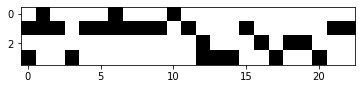

In [ ]:
# save the encoded results as 4x23 images
# we put the results in bunch
guideseq4x23 = Bunch(
    target_names=dfGuideSeq['name'].values,
    target=dfGuideSeq['label'].values,
    images=(dfGuideSeq4x23.values*254).reshape(-1,4,23, order='F')
)
plt.imshow(guideseq4x23.images[0], cmap='Greys')

In [ ]:
# we create the pkl file for later use
# pickle_out = open("guideseq4x23.pkl", "wb")
# pkl.dump(guideseq4x23, pickle_out)
# pickle_out.close()

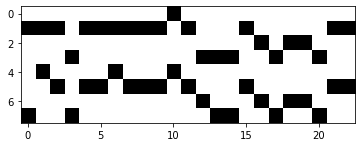

In [ ]:
# we have to transform the RNA and DNA sequences to
# a 8x23 image

# we create a new column on the crispor data df
# we strucuture the images as the mnist dataset
# digits.target_names is the name
# digits.target is the binary classification
# digits.images is the 8x23 pixels of the image
#a. we do it for the put. off-target

# we store the image in im
im = np.zeros((len(dfGuideSeq), 8, 23))

cnt = 0
for n in range(len(dfGuideSeq)):
  arr1 = one_hot_encode_seq(dfGuideSeq.loc[n, 'guideSeq'])
  # arr1 = one_hot_encode_seq(dfGuideSeq.loc[n, 'otSeq'])
  arr1 = np.asarray(arr1).T
  arr2 = one_hot_encode_seq(dfGuideSeq.loc[n, 'otSeq'])
  # arr2 = one_hot_encode_seq(dfGuideSeq.loc[n, 'guideSeq'])
  arr2 = np.asarray(arr2).T
  arr = np.concatenate((arr1, arr2)) * 254
  im[n] = arr
  cnt += 1

# we put the results in bunch
guideseq8x23 = Bunch(
    target_names = dfGuideSeq['name'].values,
    target=dfGuideSeq['label'].values,
    images=im
)
plt.imshow(guideseq8x23.images[0], cmap='Greys')
plt.savefig('guideseq8x23.pdf')

In [ ]:
# we create the pkl file for later use
# pickle_out = open("guideseq8x23.pkl", "wb")
# pkl.dump(guideseq8x23, pickle_out)
# pickle_out.close()